In [1]:
# install in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/ahmed-h-elsheikh/polychaos-learn
    %cd polychaos-learn
    !pwd
    !pip install .

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import random
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import MinMaxScaler

from pclearn import OrthogonalPolynomialsFeatures

In [14]:
def fix_random_seed(seed_):
    random.seed(seed_)
    np.random.seed(seed_)

def ackley(x):
    arg1 = -0.2 * np.sqrt(0.5 * (x[:, 0] ** 2 + x[:, 1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[:, 0]) + np.cos(2. * np.pi * x[:, 1]))
    return -20.0 * np.exp(arg1) - np.exp(arg2) + 20.0 + np.e

def ishigami_2d(x):
    # Ishigami function in 2D
    # Input: x is over the range [-np.pi, np.pi]
    part1 = 2.0 * x[:, 0] + 0.1 * np.sin(2.0 * x[:, 0])
    part2 = -3.28 * x[:, 1] + 7.0 * np.multiply(np.sin(x[:, 1]), np.sin(x[:, 1])) - 3.5
    return part1 + part2

def lhs_sample(n_samples, dim):
        """
        based on scipy/optimize/_differentialevolution.py
        Latin Hypercube Sampling ensures that the sampling of 
        parameter space is maximised.
        """
        # Generate the intervals
        segsize = 1.0 / n_samples

        # Fill points uniformly in each interval
        rdrange = np.random.rand(n_samples,dim) * segsize
        rdrange += np.atleast_2d(np.arange(0., 1., segsize)).T

        # Make the random pairings
        samples_np = np.zeros_like(rdrange)

        for j in range(dim):
            order = np.random.permutation(range(n_samples))
            samples_np[:, j] = rdrange[order, j]
        return samples_np

In [4]:
def ish_2d(x):
    # Ishigami Function in 2D
    x_0 = x[:, 0]
    x_1 = x[:, 1]
    term1 = 2.0 * x_0 + 0.1 * np.sin(2.0 * x_0)
    term2 = -3.28 * x_1 + 7.0 * np.multiply(np.sin(x_1), np.sin(x_1)) - 3.5
    y = term1 + term2
    return y

def load_ish_data(n_samples, rand_seed_):
    # generate data for modified Ishigamy function from the paper from arXiv 1808.03216
    x_all = np.random.rand(n_samples, 2)
    x_all = 2.0 * x_all - 1.0
    y_all = ish_2d(np.pi * x_all)
    return train_test_split(x_all, y_all, test_size=0.33, random_state=rand_seed_)

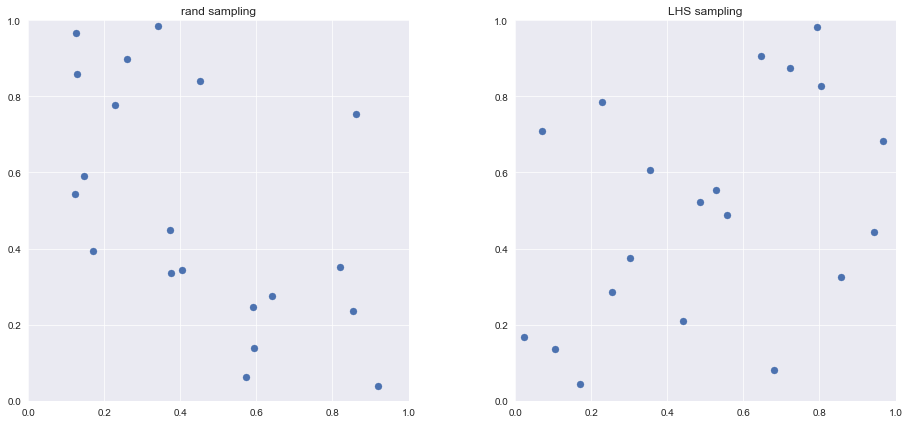

In [5]:
rand_seed_ = 123456  # random.randint(1, 10000)  # fix seed randomly
fix_random_seed(rand_seed_)

# load data set
n_samples = 20  # number of training points (number of test points is the same)

x_rand = np.random.rand(n_samples, 2)
# scale the samples form (-pi, pi)
# x_rand = np.pi * (2.0 * x_rand - 1.0)
 
x_lhs = lhs_sample(n_samples, 2)
# x_lhs = np.pi * (2.0 * x_lhs - 1.0)
fig, axs = plt.subplots(1,2, figsize=(16, 7))

axs[0].scatter(x_rand[:, 0], x_rand[:, 1])
axs[0].grid(alpha=0.75)
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 1])

axs[0].set_aspect('equal', adjustable='box')
axs[0].set_title('rand sampling')

axs[1].scatter(x_lhs[:, 0], x_lhs[:, 1])
axs[1].grid(alpha=0.75)
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 1])

axs[1].set_aspect('equal', adjustable='box')
axs[1].set_title('LHS sampling')

plt.show()

In [32]:
rand_seed_ = 123456  # random.randint(1, 10000)  # fix seed randomly
fix_random_seed(rand_seed_)

# load data set
n_samples = 2000  # number of training points (number of test points is the same)

x_rand = np.random.rand(n_samples, 2)
x_lhs = lhs_sample(n_samples, 2)

x_all = x_lhs
# scale the samples form (-pi, pi)
x_all = np.pi * (2.0 * x_all - 1.0)
y_all = ishigami_2d(x_all)

# scale the samples form (-5, 5)
x_all = 5.0 * (2.0 * x_all - 1.0)
y_all = ackley(x_all)

X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.33, random_state=rand_seed_)

n_samples_train, n_features = X_train.shape

print('Working on training data of size {} and test data of size {}'.format(X_train.shape[0], X_test.shape[0]))
print('Number of features {}'.format(X_train.shape[1]))


Working on training data of size 1340 and test data of size 660
Number of features 2


In [107]:
# define solver parameters
tol = 1.0e-6  # tolerance
n_cv_folds = 5
alphas = np.logspace(-5, 1, 5)
l1_ratio = np.linspace(0.05, 0.95, 10)
max_iter = 20000  # number of iteratons
fitting_method = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas,
                              max_iter=max_iter, tol=tol, cv=n_cv_folds,
                              fit_intercept=False, selection='random')

# define interpolation parameters
poly_degree = 20  # degree of polynomial
poly_type = ['chebyshev'] * n_features  # could be different e.g. ['legendre', 'hermite']

reduction = False
dlist = []
truncated_dim = 20
single_iter_dim = 10
niter = 500
nrand = 50

t_start = time.time()
orthopoly = OrthogonalPolynomialsFeatures(
    degree=poly_degree, dlist=dlist, poly_type=poly_type,
    reduction=reduction, basis_dim=truncated_dim,
    single_iter_dim=single_iter_dim, niter=niter, nrand=nrand,
    clf=fitting_method)

orthopoly = OrthogonalPolynomialsFeatures(
    degree=poly_degree, dlist=dlist, poly_type=poly_type)

# from sklearn.ensemble import RandomForestRegressor
# fitting_method = RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=None) 
                                       
print('Calling OrthogonalPolynomialsFeatures in {:6f} seconds'.format(time.time() - t_start))

regression_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler(feature_range=(-1, 1))),  # Legendre polynomial are defined over [-1, 1]
    ('orthopoly', orthopoly),
    ('fitting_method', fitting_method)])

t_start = time.time()
regression_pipeline.fit(X_train, y_train)
print('Linear problem (with PCE basis) has been solved in {:6f} seconds'.format(time.time() - t_start))

t_start = time.time()
y_train_pred = regression_pipeline.predict(X_train)
print('Prediction over the training data in {:6f} seconds'.format(time.time() - t_start))

t_start = time.time()
y_test_pred = regression_pipeline.predict(X_test)
print('Prediction over the test data in {:6f} seconds'.format(time.time() - t_start))

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print('MSE train: {} vs. test {}'.format(mse_train, mse_test))

Calling OrthogonalPolynomialsFeatures in 0.000116 seconds
n_output_features: 231


/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.55334784006328, tolerance: 0.4383448845700521
  tol, rng, random, positive)
/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.81430838891472, tolerance: 0.4395302095923106
  tol, rng, random, positive)
/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163.51657767339208, tolerance: 0.4364880675728271
  tol, rng, random, positive)
/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Ob

/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.13381260717242, tolerance: 0.4371415129688695
  tol, rng, random, positive)
/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.72403562184576, tolerance: 0.4345634015186326
  tol, rng, random, positive)
/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.673931553733382, tolerance: 0.4383448845700521
  tol, rng, random, positive)
/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Obje

Linear problem (with PCE basis) has been solved in 25.898387 seconds
Prediction over the training data in 0.021089 seconds
Prediction over the test data in 0.026871 seconds
MSE train: 0.37672840671316443 vs. test 0.47410488024350034


/Users/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.214267852062903, tolerance: 0.4345634015186326
  tol, rng, random, positive)


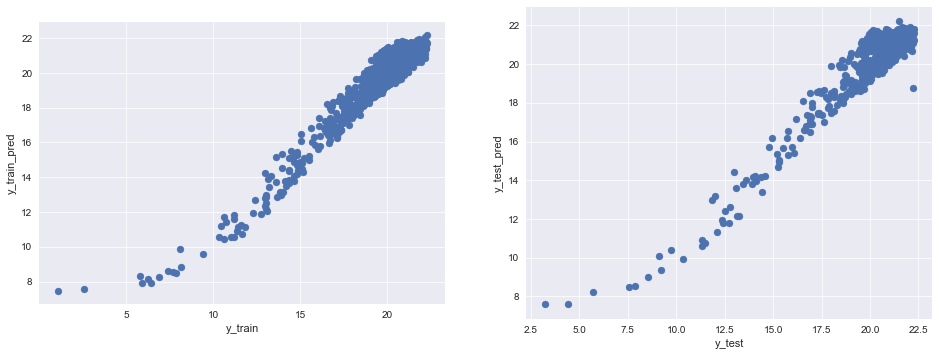

In [108]:
fig, axs = plt.subplots(1,2, figsize=(16, 7))

axs[0].scatter(y_train, y_train_pred)
axs[0].grid(alpha=0.75)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('y_train')
axs[0].set_ylabel('y_train_pred')

axs[1].scatter(y_test, y_test_pred)
axs[1].grid(alpha=0.75)
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('y_test')
axs[1].set_ylabel('y_test_pred')
plt.show()

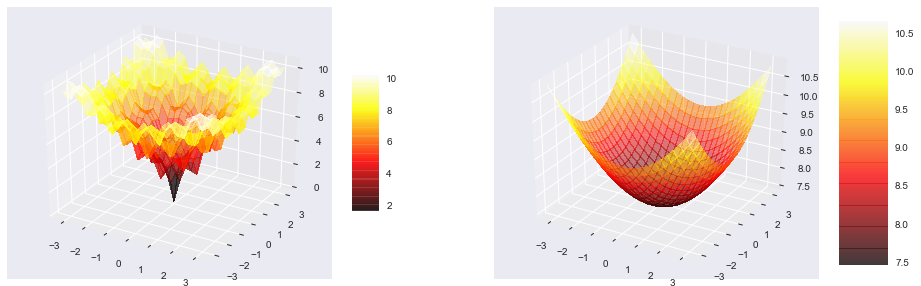

In [109]:
x = np.mgrid[-1:1:25j, -1:1:25j]
x *= np.pi

# flatten the x vector 
x_flattened = np.c_[x[0].ravel(), x[1].ravel()]
y_true = ackley(x_flattened)
y_pred = regression_pipeline.predict(x_flattened)
# reshape predictions to a grid again
y_true = y_true.reshape(x[0].shape)
y_pred = y_pred.reshape(x[0].shape)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121, projection='3d')

surf = ax.plot_surface(x[0], x[1], y_true,
                       rstride=1, cstride=1, cmap=cm.hot,
                       linewidth=0, antialiased=False, alpha=0.5)

fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.scatter(X[:, 0], X[:, 1], Z, c='r', marker='o', label="training points")
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(x[0], x[1], y_pred,
                       rstride=1, cstride=1, cmap=cm.hot,
                       linewidth=0, antialiased=False, alpha=0.5)

# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.9, aspect=5)

# ax.scatter(X[:, 0], X[:, 1], Z, c='r', marker='o', label="training points")
# # ax.set_zlim(-.41, .41)

# ax = fig.add_subplot(1, 3, 3, projection='3d')
# ax.scatter(all_points2[:, 0], all_points2[:, 1], z_predictions2-z_ref2, c='r', marker='o', label="training points")


In [27]:
x_flattened.shape

(1, 2)